In [52]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import math
import os
import statistics

In [53]:
COLOR_GLUTROT = '#DA3C43'
COLOR_HEIDENELKE = '#9C004B'

COLOR_BLUE= '#5CABFF'
COLOR_DARKBLUE = '#18206F'

COLOR_GREEN = '#7dff1a'
COLOR_DARKGREEN = '#4FB800'

COLOR_OCKER_ANDI_ORIGINAL = '#ebb300'
COLOR_OCKER_ANDI = '#EC7F00'
COLOR_OCKER = '#EA5C21'

COLOR_NONE = '#8E8E8D'
COLOR_NONE_DARK = '#4E4E4D'

PALETTE_LIGHT = [COLOR_BLUE, COLOR_GREEN, COLOR_GLUTROT, COLOR_OCKER_ANDI]
PALETTE_DARK = [COLOR_DARKBLUE, COLOR_DARKGREEN, COLOR_HEIDENELKE, COLOR_OCKER]

FRAMEWORK_ORDER = ['WinUI', 'WinAPI', 'GDIplus', 'Direct3D', 'Direct2D', 'Blend2D', 'Cairo', 'FLTK', 'Java2D', 'JavaSwing','Qt5', 'Qt6', 'pyqt5', 'pyqt6', 'pyqt6_quick', 'tkinter', 'wxpython', 'wxpython_d2d', 'SDL2_Direct3D', 'SDL2_OpenGLES', 'SDL2_OpenGL', 'SDL2_Software', 'pygame', 'pyglet', 'GTK', 'GLUT', 'GLEW', 'SFML', 'Skia']

In [54]:
PATH = "../data/finals_frameworks"

files = os.listdir(PATH)
files = [x for x in files if 'csv' in x]

In [55]:
file_data = []
for file in files:
    data_in = pd.read_csv(f"{PATH}/{file}", index_col=False)
    file_data.append(data_in)
    
data = pd.concat(file_data)

In [56]:
# exclude data we do not need for now (complexity conditions, confoundings)
data = data[data['complexity'] == 'default']
data = data[data['fullscreen'] == 'fullscreen']

We observed two absolute outliers, we remove them.

In [57]:
data[(data['framework'] == 'Skia') & (data['program'] == 'windup') & (data['diff'] < 0)]

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
1,1,1,2311,Skia,default,Skia_default,fullscreen,3.0,windup,15420,15674,9137653,-9122233


In [58]:
data[(data['framework'] == 'GDIplus') & (data['program'] == 'getpixel') & (data['diff'] > 7000)]

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
95,95,95,2310,GDIplus,default,GDIplus_default,fullscreen,2.0,getpixel,2037898,2040214,3921,2033977


In [59]:
data = data.loc[~((data['framework'] == 'GDIplus') & (data['program'] == 'getpixel') & (data['diff'] > 7000))] 
data = data.loc[~((data['framework'] == 'Skia') & (data['program'] == 'windup') & (data['diff'] < 0))] 

## Validation

In [60]:
# negative diff
negative_diffs_getpixel = data[(data['program'] == 'getpixel') & (data['diff'] < 0)]['id'].count()
negative_diffs_windup = data[(data['program'] == 'windup') & (data['diff'] < 0)]['id'].count()
negative_diffs_bitblt = data[(data['program'] == 'bitblt') & (data['diff'] < 0)]['id'].count()
negative_diffs_getdbits = data[(data['program'] == 'getdbits') & (data['diff'] < 0)]['id'].count()

# no result of measurement program
no_result_getpixel = data[(data['program'] == 'getpixel') & (data['fw'] == -1)]['id'].count()
no_result_windup = data[(data['program'] == 'windup') & (data['fw'] == -1)]['id'].count()
no_result_bitblt = data[(data['program'] == 'bitblt') & (data['fw'] == -1)]['id'].count()
no_result_getdbits = data[(data['program'] == 'getdbits') & (data['fw'] == -1)]['id'].count()

In [61]:
diff_validation = pd.DataFrame(index=['GETPIXEL', 'BITBLT', 'GETDBITS', 'DESKDUP', 'Total'], columns=['negative', 'no result', 'Total'])
diff_validation['negative']['GETPIXEL'] = negative_diffs_getpixel
diff_validation['no result']['GETPIXEL'] = no_result_getpixel
diff_validation['Total']['GETPIXEL'] = negative_diffs_getpixel + no_result_getpixel

diff_validation['negative']['BITBLT'] = negative_diffs_bitblt
diff_validation['no result']['BITBLT'] = no_result_bitblt
diff_validation['Total']['BITBLT'] = negative_diffs_bitblt + no_result_bitblt

diff_validation['negative']['GETDBITS'] = negative_diffs_getdbits
diff_validation['no result']['GETDBITS'] = no_result_getdbits
diff_validation['Total']['GETDBITS'] = negative_diffs_getdbits + no_result_getdbits

diff_validation['negative']['DESKDUP'] = negative_diffs_windup
diff_validation['no result']['DESKDUP'] = no_result_windup
diff_validation['Total']['DESKDUP'] = negative_diffs_windup + no_result_windup

diff_validation['negative']['Total'] = negative_diffs_getpixel + negative_diffs_windup + negative_diffs_bitblt + negative_diffs_getdbits
diff_validation['no result']['Total'] = no_result_getpixel + no_result_windup + no_result_bitblt + no_result_getdbits
diff_validation['Total']['Total'] = negative_diffs_getpixel + no_result_getpixel + negative_diffs_bitblt + no_result_bitblt + negative_diffs_getdbits + no_result_getdbits + negative_diffs_windup + no_result_windup


print(diff_validation.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))


diff_validation

\begin{tabular}{llll}
\toprule
 & negative & no result & Total \\
\midrule
GETPIXEL & 1 & 600 & 601 \\
BITBLT & 9 & 600 & 609 \\
GETDBITS & 4 & 800 & 804 \\
DESKDUP & 67 & 2 & 69 \\
Total & 81 & 2002 & 2083 \\
\bottomrule
\end{tabular}



,negative,no result,Total
GETPIXEL,1,600,601
BITBLT,9,600,609
GETDBITS,4,800,804
DESKDUP,67,2,69
Total,81,2002,2083


In [83]:
67 / 5800

0.011551724137931034

: 

## End-to-end Validation

In [62]:
# convert to millis instead of micros
data['ete_upper'] = data['ete_upper'] / 1000
data['ete_lower'] = data['ete_lower'] / 1000
data['fw'] = data['fw'] / 1000
data['diff'] = data['diff'] / 1000

data

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
0,0,0,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.291,13.603,4.887,6.404
1,1,1,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,12.327,14.641,6.417,5.910
2,2,2,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.633,13.950,5.467,6.166
3,3,3,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,12.471,14.785,6.739,5.732
4,4,4,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.277,13.592,5.210,6.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,2299,wxpython,default,wxpython_default,fullscreen,2.0,windup,8.009,10.332,4.494,3.515
196,196,196,2299,wxpython,default,wxpython_default,fullscreen,2.0,windup,8.011,10.335,4.916,3.095
197,197,197,2299,wxpython,default,wxpython_default,fullscreen,2.0,windup,7.496,9.646,4.322,3.174
198,198,198,2299,wxpython,default,wxpython_default,fullscreen,2.0,windup,7.330,9.647,4.029,3.301


In [63]:
data_getpixel = data[(data['program'] == 'getpixel') & data['fw'] != -0.001]
data_bitblt = data[(data['program'] == 'bitblt') & data['fw'] != -0.001]
data_getdbits = data[(data['program'] == 'getdbits') & data['fw'] != -0.001]
data_windup = data[(data['program'] == 'windup') & data['fw'] != -0.001]
data_none = data[data['program'] == 'none']

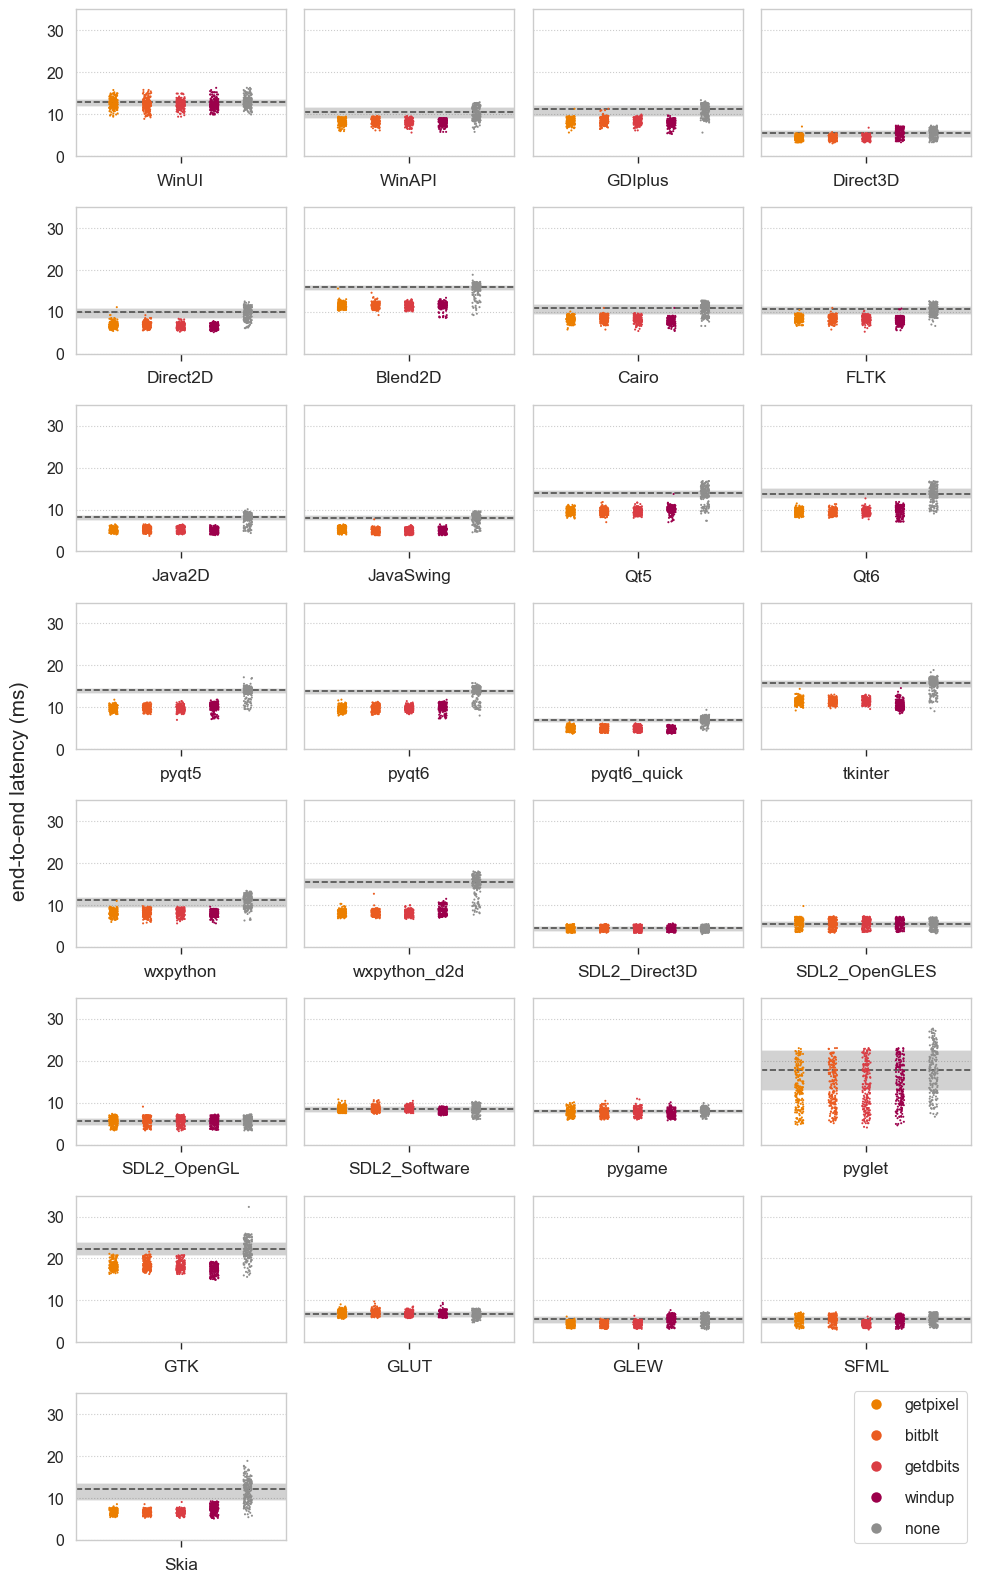

In [64]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(10, 7), "xtick.bottom": True, "grid.linestyle": ":"})
fig, axes = plt.subplots(8, 4, figsize=(10, 16), sharex=False, sharey=True)
fig.supylabel('end-to-end latency (ms)')

axes_flat = axes.flatten()

for i, (framework, ax) in enumerate(zip(FRAMEWORK_ORDER, axes_flat)):
    # plot = sns.boxplot(ax=ax, data=data[data['framework'] == framework], x='program', y='ete_upper', order=['getpixel', 'bitblt', 'getdbits', 'windup', 'none'], palette=['grey', 'grey', 'grey', 'grey', 'darkred'], fill=False)
    plot = sns.stripplot(ax=ax, data=data[data['framework'] == framework], y='ete_upper', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup', 'none'], palette=[COLOR_OCKER_ANDI, COLOR_OCKER, COLOR_GLUTROT, COLOR_HEIDENELKE, COLOR_NONE], size=1.5, dodge=True)
    handles, labels = plot.get_legend_handles_labels()
    legend = plot.get_legend()
    ax.legend().set_visible(False)
    ax.set_ylim(0, 35)
    ax.set_xlabel(framework)
    ax.set_ylabel('')
    ax.axhline(data_none[data_none['framework'] == framework]['ete_upper'].median(), color=COLOR_NONE_DARK, alpha=1, linestyle='--')
    try:
        quant_25 = np.percentile(data_none[data_none['framework'] == framework]['ete_upper'], 25)
        quant_75 = np.percentile(data_none[data_none['framework'] == framework]['ete_upper'], 75)
        ax.axhspan(quant_25, quant_75, facecolor=COLOR_NONE_DARK, alpha=0.25, label="test")
    except:
        pass


axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
axes.flat[-3].set_visible(False)


legend = fig.legend(handles, labels, loc='lower right', markerscale=5., bbox_to_anchor=(0.985, 0.025), labelspacing=1)


# handles_getpixel = (handles[0], handles[1], handles[2], handles[3])
# handles_windup = (handles[4], handles[5], handles[6], handles[7])

# handles_default = (handles[0], handles[4])
# handles_image = (handles[1], handles[5])
# handles_rects = (handles[2], handles[6])
# handles_3d = (handles[3], handles[7])

# condition_legend = plot.legend([handles_default, handles_image, handles_rects, handles_3d], ['default', 'image', 'rects', '3D'], markerscale=5., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)})
# program_legend = plot.legend([handles_windup, handles_getpixel], ['windup', 'getpixel'], markerscale=5., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)})
# plt.gca().add_artist(condition_legend)
# plt.gca().add_artist(program_legend)


plt.tight_layout() 
plt.savefig("./figures/validation_ete.pdf", format='pdf', bbox_inches='tight')

## Diff Validation

calcualte aggregated means, stds, and z-value removal

In [65]:
frameworks = data['framework'].unique()
programs = data['program'].unique().tolist()
programs.remove('none')

valids = []
for program in programs:
    for framework in frameworks:
        valid_temp = {}
        valid_temp['program'] = program
        valid_temp['framework'] = framework
        valid_temp['mean'] = data[(data['framework'] == framework) & (data['program'] == program)]['diff'].mean()
        valid_temp['std'] = data[(data['framework'] == framework) & (data['program'] == program)]['diff'].std()
        valids.append(valid_temp)

valid = pd.DataFrame.from_dict(valids)
valid

,program,framework,mean,std
0,bitblt,Blend2D,5.203080,1.167492
1,bitblt,Cairo,5.527845,0.918811
2,bitblt,Direct2D,4.490155,1.227831
3,bitblt,Direct3D,4.333315,0.558336
4,bitblt,FLTK,5.560685,0.832705
...,...,...,...,...
111,windup,tkinter,2.798240,0.605010
112,windup,WinAPI,3.341140,0.376124
113,windup,WinUI,3.220835,0.139298
114,windup,wxpython_d2d,3.525125,0.245629


In [66]:
agg_means = {}
stds = {}
for program in programs:
    agg_means[program] = valid[valid['program'] == program]['mean'].mean()
    stds[program] = valid[valid['program'] == program]['mean'].std()

In [67]:
z_value_removals = []

for program in programs:
    for framework in frameworks:
        mean_exists = True
        fw_mean_df_row = valid[(valid['program'] == program) & (valid['framework'] == framework)]
        fw_mean = fw_mean_df_row['mean'].item()
        
        if math.isnan(fw_mean):
            #print(f'already excluded {framework} {program}')
            mean_exists = False

        if mean_exists:
            if (fw_mean > agg_means[program] + (0.5 * stds[program] * 3)) or (fw_mean < agg_means[program] - (0.5 * stds[program] * 3)):
                #print(f'exclude {framework} {program}')
                z_value_removals.append({'program' : program, 'framework' : framework})
            #else:
                #print(f'valid for {framework} {program}')

z_value_removals

[{'program': 'bitblt', 'framework': 'GTK'},
 {'program': 'bitblt', 'framework': 'pyglet'},
 {'program': 'getdbits', 'framework': 'GTK'},
 {'program': 'getdbits', 'framework': 'pyglet'},
 {'program': 'getpixel', 'framework': 'GTK'},
 {'program': 'getpixel', 'framework': 'pyglet'},
 {'program': 'windup', 'framework': 'Java2D'},
 {'program': 'windup', 'framework': 'JavaSwing'},
 {'program': 'windup', 'framework': 'pygame'},
 {'program': 'windup', 'framework': 'pyqt6_quick'},
 {'program': 'windup', 'framework': 'SDL2_Direct3D'}]

In [68]:
# sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(25, 10), "xtick.bottom": True, "grid.linestyle": ":"})

# plot = sns.stripplot(data=data[data['program'] != 'none'], x='framework', y='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], size=2, dodge=True, palette=['red', 'orange', 'darkred', 'blue'])
# # plot = sns.boxplot(data=data[data['program'] != 'none'], x='framework', y='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], dodge=True, palette=['red', 'orange', 'darkred', 'blue'])
# plot.axes.set_ylim(-25, 50)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

# plt.axhline(diff_mean_getpixel, color='red')
# plt.axhline(diff_mean_bitblt, color='orange')
# plt.axhline(diff_mean_getdbits, color='darkred')
# plt.axhline(diff_mean_windup, color='blue')


In [69]:
data_ete_median_diffs = pd.DataFrame(columns=['framework', 'none', 'getpixel', 'diff getpixel', 'bitblt', 'diff bitblt', 'getdbits', 'diff getdbits', 'windup', 'diff windup'])

for i, framework in enumerate(data['framework'].unique()):
    fw_data = data[data['framework'] == framework]
    data_ete_median_diffs.at[i, 'framework'] = framework
    data_ete_median_diffs.at[i, 'none'] = fw_data[fw_data['program'] == 'none']['ete_upper'].median()
    data_ete_median_diffs.at[i, 'getpixel'] = fw_data[fw_data['program'] == 'getpixel']['ete_upper'].median()
    data_ete_median_diffs.at[i, 'bitblt'] = fw_data[fw_data['program'] == 'bitblt']['ete_upper'].median()
    data_ete_median_diffs.at[i, 'getdbits'] = fw_data[fw_data['program'] == 'getdbits']['ete_upper'].median()
    data_ete_median_diffs.at[i, 'windup'] = fw_data[fw_data['program'] == 'windup']['ete_upper'].median()

data_ete_median_diffs['diff getpixel'] = data_ete_median_diffs['getpixel'] - data_ete_median_diffs['none']
data_ete_median_diffs['diff bitblt'] = data_ete_median_diffs['bitblt'] - data_ete_median_diffs['none']
data_ete_median_diffs['diff getdbits'] = data_ete_median_diffs['getdbits'] - data_ete_median_diffs['none']
data_ete_median_diffs['diff windup'] = data_ete_median_diffs['windup'] - data_ete_median_diffs['none']

data_ete_median_diffs['framework'] = pd.Categorical(data_ete_median_diffs['framework'], categories=FRAMEWORK_ORDER, ordered=True)
df_sorted = data_ete_median_diffs.sort_values(by='framework')
df_sorted

,framework,none,getpixel,diff getpixel,bitblt,diff bitblt,getdbits,diff getdbits,windup,diff windup
26,WinUI,12.839,12.5735,-0.2655,12.1735,-0.6655,12.3275,-0.5115,12.3075,-0.5315
25,WinAPI,10.417,8.189,-2.228,8.2725,-2.1445,8.1855,-2.2315,8.016,-2.401
5,GDIplus,11.204,8.199,-3.005,8.359,-2.845,8.358,-2.846,8.0165,-3.1875
3,Direct3D,5.4135,4.353,-1.0605,4.348,-1.0655,4.356,-1.0575,5.414,0.0005
2,Direct2D,10.079,6.8115,-3.2675,6.8085,-3.2705,6.6375,-3.4415,6.476,-3.603
0,Blend2D,15.934,11.547,-4.387,11.4535,-4.4805,11.451,-4.483,11.4595,-4.4745
1,Cairo,10.944,8.1895,-2.7545,8.3565,-2.5875,8.2735,-2.6705,7.842,-3.102
4,FLTK,10.7695,8.3515,-2.418,8.3535,-2.416,8.3565,-2.413,7.84,-2.9295
9,Java2D,8.1835,5.1005,-3.083,5.2605,-2.923,5.1765,-3.007,5.088,-3.0955
10,JavaSwing,8.02,5.0905,-2.9295,5.0835,-2.9365,4.917,-3.103,4.9215,-3.0985


In [70]:
df_values_only = df_sorted.drop(['framework'], axis=1)
df_values_only.loc['mean'] = df_values_only.mean()
df_values_only

,none,getpixel,diff getpixel,bitblt,diff bitblt,getdbits,diff getdbits,windup,diff windup
26,12.839,12.5735,-0.2655,12.1735,-0.6655,12.3275,-0.5115,12.3075,-0.5315
25,10.417,8.189,-2.228,8.2725,-2.1445,8.1855,-2.2315,8.016,-2.401
5,11.204,8.199,-3.005,8.359,-2.845,8.358,-2.846,8.0165,-3.1875
3,5.4135,4.353,-1.0605,4.348,-1.0655,4.356,-1.0575,5.414,0.0005
2,10.079,6.8115,-3.2675,6.8085,-3.2705,6.6375,-3.4415,6.476,-3.603
0,15.934,11.547,-4.387,11.4535,-4.4805,11.451,-4.483,11.4595,-4.4745
1,10.944,8.1895,-2.7545,8.3565,-2.5875,8.2735,-2.6705,7.842,-3.102
4,10.7695,8.3515,-2.418,8.3535,-2.416,8.3565,-2.413,7.84,-2.9295
9,8.1835,5.1005,-3.083,5.2605,-2.923,5.1765,-3.007,5.088,-3.0955
10,8.02,5.0905,-2.9295,5.0835,-2.9365,4.917,-3.103,4.9215,-3.0985


In [71]:
# df_sorted.round({'none':2, 'getpixel':2, 'diff getpixel':2, 'bitblt':2, 'diff bitblt':2, 'getdbits':2, 'diff getdbits':2, 'windup':2, 'diff windup':2})
df_rounded = df_sorted.copy()
df_rounded['none'] = df_rounded['none'].astype(float).round(2)
df_rounded['getpixel'] = df_rounded['getpixel'].astype(float).round(2)
df_rounded['diff getpixel'] = df_rounded['diff getpixel'].astype(float).round(2)
df_rounded['bitblt'] = df_rounded['bitblt'].astype(float).round(2)
df_rounded['diff bitblt'] = df_rounded['diff bitblt'] .astype(float).round(2)
df_rounded['getdbits'] = df_rounded['getdbits'].astype(float).round(2)
df_rounded['diff getdbits'] = df_rounded['diff getdbits'].astype(float).round(2)
df_rounded['windup'] = df_rounded['windup'].astype(float).round(2)
df_rounded['diff windup'] = df_rounded['diff windup'].astype(float).round(2)

print(df_rounded.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))

df_rounded

\begin{tabular}{lrrrrrrrrr}
\toprule
framework & none & getpixel & diff getpixel & bitblt & diff bitblt & getdbits & diff getdbits & windup & diff windup \\
\midrule
WinUI & 12.84 & 12.57 & -0.27 & 12.17 & -0.67 & 12.33 & -0.51 & 12.31 & -0.53 \\
WinAPI & 10.42 & 8.19 & -2.23 & 8.27 & -2.14 & 8.19 & -2.23 & 8.02 & -2.40 \\
GDIplus & 11.20 & 8.20 & -3.01 & 8.36 & -2.85 & 8.36 & -2.85 & 8.02 & -3.19 \\
Direct3D & 5.41 & 4.35 & -1.06 & 4.35 & -1.07 & 4.36 & -1.06 & 5.41 & 0.00 \\
Direct2D & 10.08 & 6.81 & -3.27 & 6.81 & -3.27 & 6.64 & -3.44 & 6.48 & -3.60 \\
Blend2D & 15.93 & 11.55 & -4.39 & 11.45 & -4.48 & 11.45 & -4.48 & 11.46 & -4.47 \\
Cairo & 10.94 & 8.19 & -2.75 & 8.36 & -2.59 & 8.27 & -2.67 & 7.84 & -3.10 \\
FLTK & 10.77 & 8.35 & -2.42 & 8.35 & -2.42 & 8.36 & -2.41 & 7.84 & -2.93 \\
Java2D & 8.18 & 5.10 & -3.08 & 5.26 & -2.92 & 5.18 & -3.01 & 5.09 & -3.10 \\
JavaSwing & 8.02 & 5.09 & -2.93 & 5.08 & -2.94 & 4.92 & -3.10 & 4.92 & -3.10 \\
Qt5 & 14.04 & 9.48 & -4.56 & 9.57 & -4.47 & 9

,framework,none,getpixel,diff getpixel,bitblt,diff bitblt,getdbits,diff getdbits,windup,diff windup
26,WinUI,12.84,12.57,-0.27,12.17,-0.67,12.33,-0.51,12.31,-0.53
25,WinAPI,10.42,8.19,-2.23,8.27,-2.14,8.19,-2.23,8.02,-2.40
5,GDIplus,11.20,8.20,-3.01,8.36,-2.85,8.36,-2.85,8.02,-3.19
3,Direct3D,5.41,4.35,-1.06,4.35,-1.07,4.36,-1.06,5.41,0.00
2,Direct2D,10.08,6.81,-3.27,6.81,-3.27,6.64,-3.44,6.48,-3.60
0,Blend2D,15.93,11.55,-4.39,11.45,-4.48,11.45,-4.48,11.46,-4.47
1,Cairo,10.94,8.19,-2.75,8.36,-2.59,8.27,-2.67,7.84,-3.10
4,FLTK,10.77,8.35,-2.42,8.35,-2.42,8.36,-2.41,7.84,-2.93
9,Java2D,8.18,5.10,-3.08,5.26,-2.92,5.18,-3.01,5.09,-3.10
10,JavaSwing,8.02,5.09,-2.93,5.08,-2.94,4.92,-3.10,4.92,-3.10


C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_18264\2530109682.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  plot = sns.pointplot(data=data_temp, y='framework', order=FRAMEWORK_ORDER, x='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], palette=[COLOR_OCKER_ANDI, COLOR_OCKER, COLOR_GLUTROT, COLOR_HEIDENELKE], dodge=0.6, join=False, estimator=np.median, errorbar='sd', markersize=3, linewidth=1.5, zorder=2)


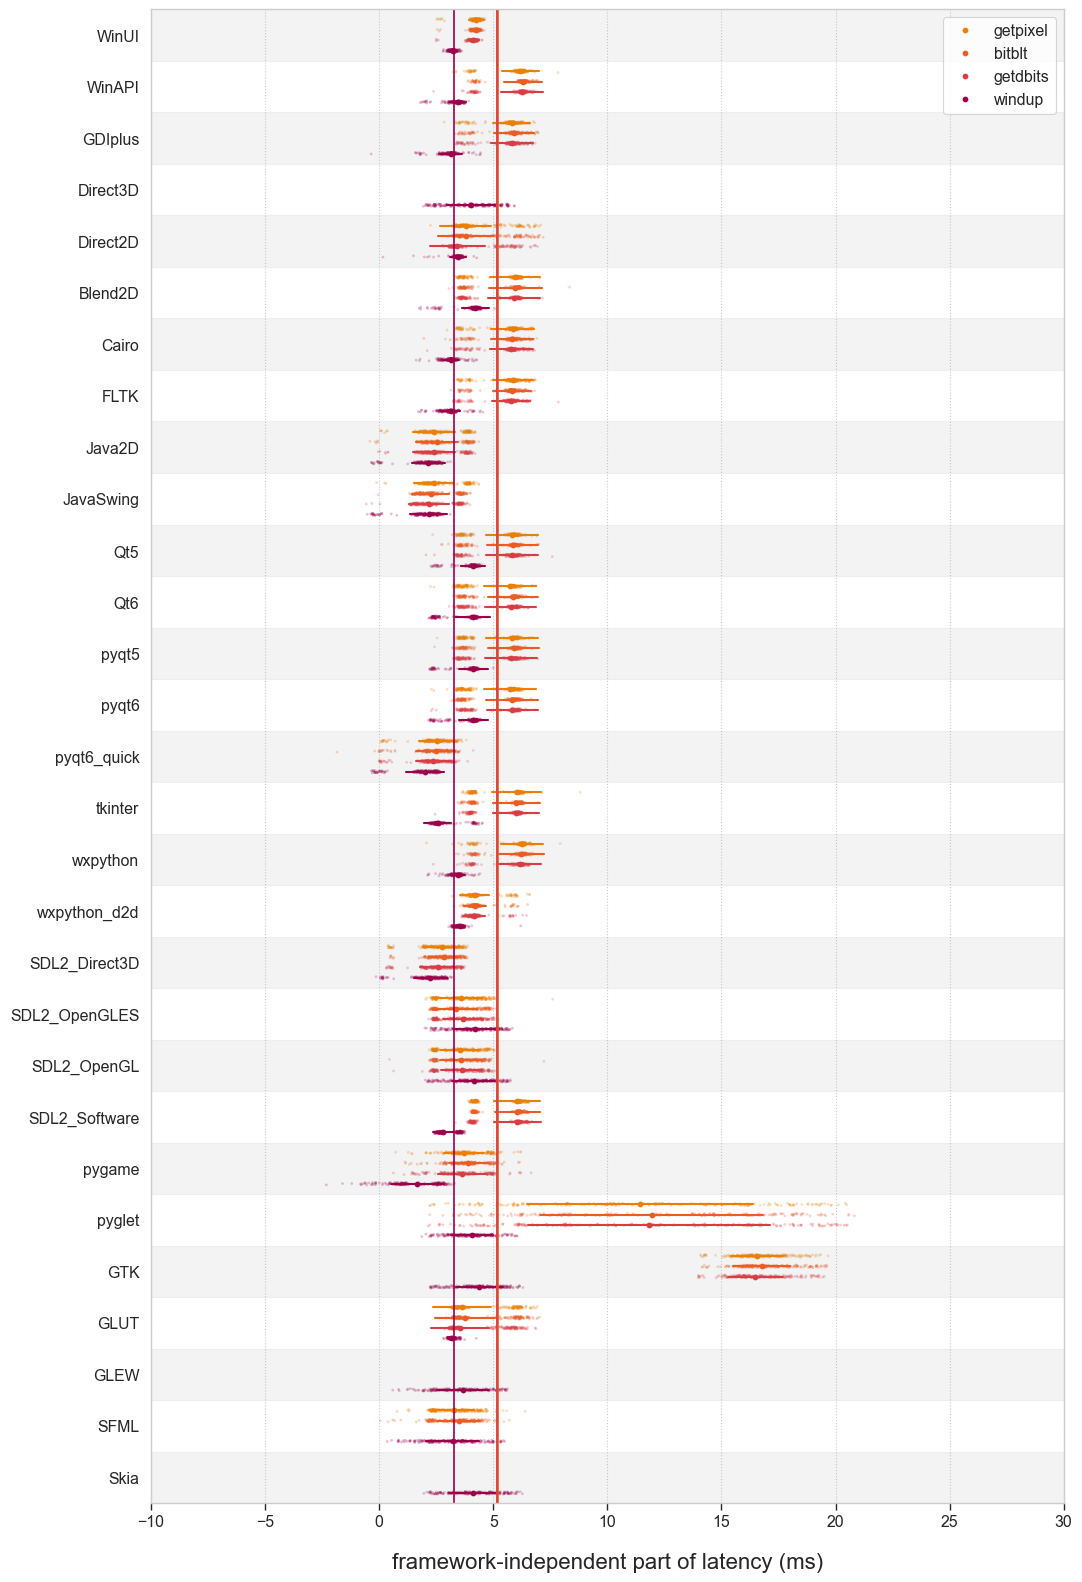

In [72]:
data_temp = data[data['fw'] != -0.001]  # exclude wherever fw measurement was not possible + no measurement program running

sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(11, 16), "xtick.bottom": True, "grid.linestyle": ":"})

plot = sns.stripplot(data=data_temp, y='framework', order=FRAMEWORK_ORDER, x='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], size=2, dodge=0.6, palette=[COLOR_OCKER_ANDI, COLOR_OCKER, COLOR_GLUTROT, COLOR_HEIDENELKE], alpha=0.25, zorder=1, legend=False)
plot = sns.pointplot(data=data_temp, y='framework', order=FRAMEWORK_ORDER, x='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], palette=[COLOR_OCKER_ANDI, COLOR_OCKER, COLOR_GLUTROT, COLOR_HEIDENELKE], dodge=0.6, join=False, estimator=np.median, errorbar='sd', markersize=3, linewidth=1.5, zorder=2)
plot.axes.set_xlim(-10, 30)
plot.legend(title='', loc='upper right')
plot.set_xlabel('framework-independent part of latency (ms)', fontsize=16)
plot.xaxis.labelpad = 16
plot.set_ylabel('')


# stripped background
for i in range(len(data['framework'].unique())):
    if i % 2 == 0:
        plot.axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
plot.set_ylim(-0.5, len(data['framework'].unique()) - 0.5)


plt.axvline(agg_means['getpixel'], color=COLOR_OCKER_ANDI)
plt.axvline(agg_means['bitblt'], color=COLOR_OCKER)
plt.axvline(agg_means['getdbits'], color=COLOR_GLUTROT)
plt.axvline(agg_means['windup'], color=COLOR_HEIDENELKE)


plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("./figures/validation_diffs.pdf", format='pdf', bbox_inches='tight')



In [79]:
agg_means['getpixel'] - agg_means['windup']
# agg_means['bitblt']
# agg_means['getdbits']
# agg_means['windup']


1.877156038814762